In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import matplotlib.pyplot as plt
import zlib
import sys
import compress
import random
import lzma

In [4]:
from compress import Compressor
c = Compressor()
c.use_zlib()

In [6]:
data_df = pd.read_csv('C1_160313.txt', sep=",", engine='python')
data_df.columns = ['Time', 'X', 'Y', 'Z']
data_df.astype({'Y': 'float64'})

,Time,X,Y,Z
0,1457857818.466883691,-8.4609,8.4766,4.5234
1,1457857818.481750410,-8.4453,8.5234,4.5781
2,1457857818.496617129,-8.4922,8.5078,4.6094
3,1457857818.511483848,-8.5000,8.9922,4.4609
4,1457857818.526350567,-8.4609,9.1953,4.4219
...,...,...,...,...
724656,1457868591.660651464,-1.3672,7.3516,4.5781
724657,1457868591.675518183,-1.3984,7.4688,4.5312
724658,1457868591.690384902,-1.3750,7.9609,4.3906
724659,1457868591.705251621,-1.3672,8.1172,4.4844


In [7]:
data_df = data_df.dropna()
data_df.isnull().sum()

Time    0
X       0
Y       0
Z       0
dtype: int64

In [8]:
data_df['X'] = data_df['X']/0.0078125
data_df['Y'] = data_df['Y']/0.0078125
data_df['Z'] = data_df['Z']/0.0078125
data_df = data_df.astype({'X': 'int16',
               'Y': 'int16',
               'Z': 'int16'})
data_df.dtypes

Time    object
X        int16
Y        int16
Z        int16
dtype: object

In [32]:
data_df

,Time,X,Y,Z
0,1457857818.466883691,-1082,1085,578
1,1457857818.481750410,-1080,1090,585
2,1457857818.496617129,-1087,1088,590
3,1457857818.511483848,-1088,1151,570
4,1457857818.526350567,-1082,1176,566
...,...,...,...,...
724656,1457868591.660651464,-175,941,585
724657,1457868591.675518183,-178,956,579
724658,1457868591.690384902,-176,1018,561
724659,1457868591.705251621,-175,1039,574


In [33]:
data_df.isnull().sum()

Time    0
X       0
Y       0
Z       0
dtype: int64

In [26]:
data_df = data_df.astype({'Time': 'float64'})
data_df.dtypes

Time    float64
X         int32
Y         int32
Z         int32
dtype: object

# 1 second, vary zlib level, measure final size of data (check time for compression later)
# ALSO THIS IS FOR SINGLE LIST COMPRESSION NOT 3D ARRAY

In [29]:
start = random.randint(0, 650000)
df_chunk = data_df[start: start+64]

In [69]:
time = np.array(df_chunk['Time'].tolist())
x_values = np.array(df_chunk['X'].tolist())
y_values = np.array(df_chunk['Y'].tolist())
z_values = np.array(df_chunk['Z'].tolist())
x_values

array([-65547, -65469, -65391, -65781, -65938, -65859, -65703, -65391,
       -65625, -65938, -65859, -66016, -65938, -65859, -65625, -65859,
       -66250, -65703, -65781, -65859, -65625, -65781, -65859, -66016,
       -66016, -66562, -66250, -66406, -66172, -66328, -66562, -66172,
       -66250, -66406, -66094, -66797, -66641, -66406, -66250, -66328,
       -66328, -66484, -66406, -66406, -66172, -66172, -66562, -66641,
       -65859, -66172, -66641, -66562, -66328, -66875, -66641, -66875,
       -66875, -66953, -66484, -66562, -66562, -66953, -66953, -66875])

In [117]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = zlib.compress(bytes(comp_x.encode('utf-8')), 9)
decomp_x = zlib.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)

True


In [120]:
def compressed_size(values_array, level):
    values = [str(x) for x in values_array]
    values_str = ','.join(values)
    initial = values_str.split(',')
    
    comp_values = zlib.compress(bytes(values_str.encode('utf-8')), level)
    decomp_values = zlib.decompress(comp_values).decode()
    final = decomp_values.split(',')
    if not initial == final:
        raise Exception('Decompressed does not equal compressed')
    return sys.getsizeof(comp_values)

In [190]:
# use zlib levels of 1, 5, 9
uncomp_values = []
comp_values1 = []
comp_values5 = []
comp_values9 = []

comp_values_t1 = []
comp_values_t5 = []
comp_values_t9 = []

comp_values_x1 = []
comp_values_x5 = []
comp_values_x9 = []

comp_values_y1 = []
comp_values_y5 = []
comp_values_y9 = []

comp_values_z1 = []
comp_values_z5 = []
comp_values_z9 = []

for i in range(10000):
    start = random.randint(0, 650000)
    df_chunk = data_df[start: start+64]
    
    time = np.array(df_chunk['Time'].tolist())
    x_values = np.array(df_chunk['X'].tolist())
    y_values = np.array(df_chunk['Y'].tolist())
    z_values = np.array(df_chunk['Z'].tolist())
    
    uncomp_values.append(sys.getsizeof(time) +
                        sys.getsizeof(x_values) +
                        sys.getsizeof(y_values) +
                        sys.getsizeof(z_values))
    
    comp_values_t1.append(compressed_size(time, 1))
    comp_values_t5.append(compressed_size(time, 5))
    comp_values_t9.append(compressed_size(time, 9))
    
    comp_values_x1.append(compressed_size(x_values, 1))
    comp_values_x5.append(compressed_size(x_values, 5))
    comp_values_x9.append(compressed_size(x_values, 9))
    
    comp_values_y1.append(compressed_size(y_values, 1))
    comp_values_y5.append(compressed_size(y_values, 5))
    comp_values_y9.append(compressed_size(y_values, 9))
    
    comp_values_z1.append(compressed_size(z_values, 1))
    comp_values_z5.append(compressed_size(z_values, 5))
    comp_values_z9.append(compressed_size(z_values, 9))
    
    total1 = sys.getsizeof(compressed_size(time, 1))+sys.getsizeof(compressed_size(x_values, 1))+sys.getsizeof(compressed_size(y_values, 1))+sys.getsizeof(compressed_size(z_values, 1))
    total5 = sys.getsizeof(compressed_size(time, 5))+sys.getsizeof(compressed_size(x_values, 5))+sys.getsizeof(compressed_size(y_values, 5))+sys.getsizeof(compressed_size(z_values, 5))
    total9 = sys.getsizeof(compressed_size(time, 9))+sys.getsizeof(compressed_size(x_values, 9))+sys.getsizeof(compressed_size(y_values, 9))+sys.getsizeof(compressed_size(z_values, 9))
    
    comp_values1.append(total1)
    
    comp_values5.append(total5)
    
    comp_values9.append(total9)
    

In [197]:
print(min(uncomp_values), max(uncomp_values))
print(min(comp_values1), max(comp_values1))
print(min(comp_values9), max(comp_values9))
print(min(comp_values9), max(comp_values9))

1664 1664
112 112
112 112
112 112


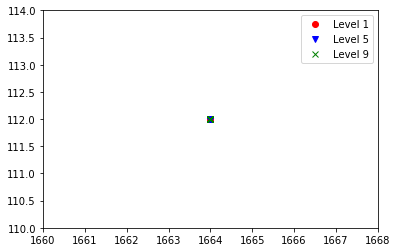

In [192]:
plt.plot(uncomp_values, comp_values1, 'ro', label='Level 1')
plt.plot(uncomp_values, comp_values5, 'bv', label='Level 5')
plt.plot(uncomp_values, comp_values9, 'gx', label='Level 9')
plt.axis([1660, 1668, 110, 114])
plt.legend()
plt.show()

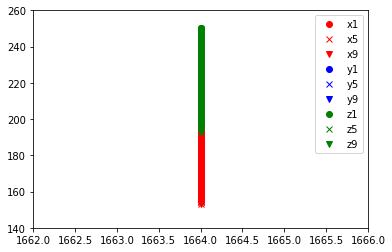

In [193]:
plt.plot(uncomp_values, comp_values_x1, 'ro', label='x1')
plt.plot(uncomp_values, comp_values_x5, 'rx', label='x5')
plt.plot(uncomp_values, comp_values_x9, 'rv', label='x9')
plt.plot(uncomp_values, comp_values_y1, 'bo', label='y1')
plt.plot(uncomp_values, comp_values_y5, 'bx', label='y5')
plt.plot(uncomp_values, comp_values_y9, 'bv', label='y9')
plt.plot(uncomp_values, comp_values_z1, 'go', label='z1')
plt.plot(uncomp_values, comp_values_z5, 'gx', label='z5')
plt.plot(uncomp_values, comp_values_z9, 'gv', label='z9')
plt.axis([1662, 1666, 140, 260])
plt.legend()
plt.show()

# LZMA

In [199]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = lzma.compress(bytes(comp_x.encode('utf-8')))
decomp_x = lzma.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)
print(sys.getsizeof(initial))
print(sys.getsizeof(comp_x))

True
576
277


In [171]:
comp_x = [str(x) for x in x_values]
comp_x = ','.join(comp_x)
initial = comp_x.split(',')

comp_x = snappy.compress(bytes(comp_x.encode('utf-8')))
decomp_x = snappy.decompress(comp_x).decode()
final = decomp_x.split(',')
print(initial == final)
# print(initial)
# print(final)

AttributeError: module 'snappy' has no attribute 'compress'

# RANDOM

In [9]:
st = '1'
print(''.join('{0:014b}'.format(ord(x), 'b') for x in st))
print('{0:014b}'.format(-3))

00000000110001
-0000000000011


In [10]:
data_df.describe()

,X,Y,Z
count,710907.000000,710907.000000,710907.000000
mean,-798.749368,1045.176643,-100.195964
std,183.360972,478.466824,485.161339
min,-1279.000000,-485.000000,-1433.000000
25%,-883.000000,598.000000,-554.000000
50%,-822.000000,1046.000000,-99.000000
75%,-713.000000,1493.500000,354.000000
max,47.000000,2325.000000,1144.000000


In [13]:
t_values = data_df['Time'].tolist()
x_values = data_df['X'].tolist()
y_values = data_df['Y'].tolist()
z_values = data_df['Z'].tolist()
type(x_values)

list

In [ ]:
def difference_coding(number_of_values, values, start_num):
    num_of_readings = number_of_values
    full_values = values[start_num: start_num + num_of_readings]
    

In [51]:
codes={}

def frequency (str) :
    freqs = {}
    for ch in str :
        freqs[ch] = freqs.get(ch,0) + 1
    return freqs

def sortFreq (freqs) :
    letters = freqs.keys()
    tuples = []
    for let in letters :
        tuples.append((freqs[let],let))
    tuples.sort()
    return tuples

def buildTree(tuples) :
    while len(tuples) > 1 :
        leastTwo = tuple(tuples[0:2])                  # get the 2 to combine
        theRest  = tuples[2:]                          # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]     # the branch points freq
        tuples   = theRest + [(combFreq,leastTwo)]     # add branch point to the end
#         print(tuples)
        tuples.sort(key=lambda t: t[0])                                  # sort it into place
    return tuples[0]            # Return the single tree inside the list

def trimTree (tree) :
     # Trim the freq counters off, leaving just the letters
    p = tree[1]                                    # ignore freq count in [0]
    if type(p) == type("") : return p              # if just a leaf, return it
    else : return (trimTree(p[0]), trimTree(p[1])) # trim left then right and recombine
    
def assignCodes (node, pat='') :
    global codes
    if type(node) == type("") :
        codes[node] = pat                # A leaf. set its code
    else  :                              #
        assignCodes(node[0], pat+"0")    # Branch point. Do the left branch
        assignCodes(node[1], pat+"1")    # then do the right branch.

def encode_str (str) :
    global codes
    output = ""
    for ch in str : output += codes[ch]
    return output

def decode_str (tree, string_to_decode) :
    output = ""
    p = tree
    for bit in string_to_decode:
#         print(bit, type(bit), p)
        if bit == '0' : p = p[0]     # Head up the left branch
        else          : p = p[1]     # or up the right branch
        if type(p) == type("") :
            output += p              # found a character. Add to output
            p = tree                 # and restart for next character
    return output

original_str = 'aaabccdeeeeeffg'
qwe = frequency('aaabccdeeeeeffg')
print('frequencies:', qwe)
print('-'*20)
tuples_for_tree = sortFreq(qwe)
print('sorted freq:', tuples_for_tree)
print('-'*20)
tree = buildTree(tuples_for_tree)
print('tree:', tree)
print('-'*20)
trimmed = trimTree(tree)
print('trimmed tree:', trimmed)
print('-'*20)
assignCodes(trimmed)
print('assignment of codes:', codes)
print('-'*20)
print('encoded:', encode_str('aaabccdeeeeeffg'))
print('-'*20)
decoded = decode_str(trimmed, '000000101001101110111111111111100100010')
print('decoded:', decoded)
print('-'*20)
print('Original matches decoded:', decoded == original_str)

frequencies: {'a': 3, 'b': 1, 'c': 2, 'd': 1, 'e': 5, 'f': 2, 'g': 1}
--------------------
sorted freq: [(1, 'b'), (1, 'd'), (1, 'g'), (2, 'c'), (2, 'f'), (3, 'a'), (5, 'e')]
--------------------
tree: (15, ((6, ((3, 'a'), (3, ((1, 'g'), (2, 'c'))))), (9, ((4, ((2, 'f'), (2, ((1, 'b'), (1, 'd'))))), (5, 'e')))))
--------------------
trimmed tree: (('a', ('g', 'c')), (('f', ('b', 'd')), 'e'))
--------------------
assignment of codes: {'a': '00', 'g': '010', 'c': '011', 'f': '100', 'b': '1010', 'd': '1011', 'e': '11'}
--------------------
encoded: 000000101001101110111111111111100100010
--------------------
decoded: aaabccdeeeeeffg
--------------------
Original matches decoded: True


In [98]:
start = random.randint(0, 650000)
num_of_readings = 70
initial = x_values[start]
full_values = x_values[start: start+num_of_readings]
full_joined = ','.join(map(str, full_values))
new = []
for i in range(start, start+num_of_readings):
    new.append(x_values[i]-initial)

lst_joined = ','.join(map(str, new))
final_str = str(initial)+':'+lst_joined
print('Calculated Differences size:', sys.getsizeof(final_str))
print('Actual calculated differences string:', final_str)
print('--'*20)
print('Uncompressed size:', sys.getsizeof(full_joined))
print('Full uncompressed string:', full_joined)
print('--'*20)
# print(sys.getsizeof(final_str.encode('utf-8')), final_str.encode('utf-8'))
# print('--'*20)
print('zlib compressed size:', sys.getsizeof(zlib.compress(final_str.encode('utf-8'))))
print('--'*20)
codes={}
qwe = frequency(final_str)
tuples_for_tree = sortFreq(qwe)
tree = buildTree(tuples_for_tree)
trimmed = trimTree(tree)
assignCodes(trimmed)
encoded = encode_str(final_str)
decoded = decode_str(trimmed, encoded)
# print(codes)
# print('encoded:', encoded)
print('length of huffman encoded in bits?:', len(encoded))
print('length in bytes:', len(encoded)/8)
print('huffman encoded size:', sys.getsizeof(encoded.encode('utf-8')))
print('Original matches decoded:', decoded == final_str)
# print('decoded:', decoded)
# print('bytes form:', bytes(encoded.encode('utf-8')))

Calculated Differences size: 226
Actual calculated differences string: -1143:0,-1,-7,4,5,6,4,10,13,9,8,7,10,11,7,22,27,31,25,29,27,22,23,23,18,14,10,8,7,-5,-11,-16,-15,-7,-2,-5,-6,-9,-1,6,8,15,27,33,39,49,54,53,52,63,63,55,55,53,48,41,36,39,39,32,29,33,24,17,15,7,7,5,5,13
----------------------------------------
Uncompressed size: 444
Full uncompressed string: -1143,-1144,-1150,-1139,-1138,-1137,-1139,-1133,-1130,-1134,-1135,-1136,-1133,-1132,-1136,-1121,-1116,-1112,-1118,-1114,-1116,-1121,-1120,-1120,-1125,-1129,-1133,-1135,-1136,-1148,-1154,-1159,-1158,-1150,-1145,-1148,-1149,-1152,-1144,-1137,-1135,-1128,-1116,-1110,-1104,-1094,-1089,-1090,-1091,-1080,-1080,-1088,-1088,-1090,-1095,-1102,-1107,-1104,-1104,-1111,-1114,-1110,-1119,-1126,-1128,-1136,-1136,-1138,-1138,-1130
----------------------------------------
zlib compressed size: 129
----------------------------------------
length of huffman encoded in bits?: 638
length in bytes: 79.75
huffman encoded size: 655
Original matches dec

In [96]:
os.getcwd()

'E:\\BSc Project\\data_compression-master'